![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [135]:
# QuantConnect Imports
%load_ext autoreload
%autoreload 2

from clr import AddReference
AddReference("System")
AddReference('System.Memory')
AddReference("QuantConnect.Algorithm")
AddReference("QuantConnect.Api")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Configuration")
AddReference("QuantConnect.Research")
AddReference("QuantConnect.Indicators")

from System import *
from QuantConnect import *
from QuantConnect.Algorithm import * 
from QuantConnect.Api import *
from QuantConnect.Configuration import *
from QuantConnect.Data import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Research import *
from QuantConnect.Indicators import *

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd

# PT imports 
import numpy as np 
import matplotlib.pylab as plt 
from rolling_win import * 

# ipython debugger. set breakpoint with `dbg.set_trace()` 
import IPython.core.debugger as dbg

# execute this to connect to QuantConnect API 
api = Api()
api.Initialize(
    Config.GetInt("job-user-id", 94240), 
    Config.Get("api-access-token", "f9683aa5c308894f2238228a5f3545badd2e4b11526685cee58bb1cecf7e9f30"),
    Config.Get("data-folder"))
print(api.Connected)


# Create an quantBook instance
qb = QuantBook()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True


In [136]:
# load appl into the securities list and get the history of all the added securities 
apl = qb.AddEquity("AAPL")
ggl = qb.AddEquity("GOOGL")
spy = qb.AddEquity('SPY')

DIM = 21 
DIY = 12*DIM
LOOKBACK = 5*DIY

history = qb.History(qb.Securities.Keys, LOOKBACK, Resolution.Daily) 
apl_df = history.loc[apl.Symbol]
ggl_df = history.loc[ggl.Symbol]
spy_df = history.loc[spy.Symbol]


In [137]:
ggl_df = history.xs(ggl.Symbol, drop_level=True).sort_index(ascending=False)
period = len(ggl_df)-10
rw = MyRollingWindow(period)
rw.batch_update(history)
ggl_df = rw._df.xs(ggl.Symbol, drop_level=True)

In [138]:
# Test 1 
lag = 10
mom1 = ggl_df.pct_change(-lag).dropna()['close']
mom2 = mk_momentum(rw,m=0,n=lag).xs(ggl.Symbol, drop_level=True)['close']
# assert and compare 
assert(np.all(np.abs(mom1[0:len(mom2)] - mom2[0:])  < 1e-12) )
assert(mom2.index.nlevels == 1)

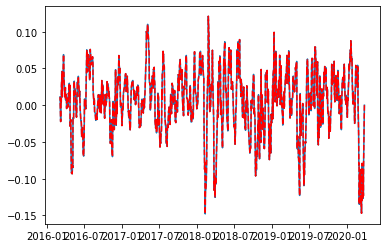

In [139]:
plt.plot(mom1[0:len(mom2)])
plt.plot(mom2, '--r')

In [140]:
# Test 2 
lag1 = 10
lag2 = 2 
mom1 = ggl_df.pct_change(-lag).dropna().shift(-lag2).dropna()['close']
mom2 = mk_momentum(rw, m=lag2,n=lag1).xs(ggl.Symbol, drop_level=True)['close']
# assert and compare 
assert(np.all(np.abs(mom1[0:len(mom2)] - mom2[0:])  < 1e-12) )
assert(mom2.index.nlevels == 1)

In [141]:
# test 3  Sigma
window = 10 
sig1 = ggl_df['close'].rolling(window).std().shift(-window+1).dropna()
sig2 = mk_sigma(rw.data(), window).xs(ggl.Symbol, drop_level=True)['close']
# manual computation of the first element 
sig3 = ggl_df['close'][0:window].std()
sig3 == sig1[0]
assert(np.all(np.abs(sig1[0:len(sig2)] -sig2[0:]) < 1e-12 ) )
assert(np.abs(sig1[0] - sig3) < 1e-12 and np.abs(sig2[0] - sig3) < 1e-12)
assert(sig2.index.nlevels == 1)


In [106]:
tbs = []
for bar in history.itertuples():
    tbs = tbs + [TradeBar(bar.Index[1], bar.Index[0],
                        bar.open,
                        bar.high, 
                        bar.low,
                        bar.close,
                        bar.volume)]

In [107]:
def mk_dataframe(symbols, time, bar):
    """
    transform a dictionary of bar data into pandas dataframe 
    """
    df = pd.DataFrame(columns = ["close", "high" ,"low" ,"open", "volume"])
    for symbol in symbols: 
        _ = bar[symbol]
        _ = pd.DataFrame({"close" : [_.Close], "high":[_.High], 
                      "low":[_.Low], "open" :[_.Open], "volume" :[ _.Volume]})
        df = pd.concat([df,_], ignore_index = True)
    
    midx = pd.MultiIndex.from_product([symbols,[time]], names = ["symbol","time"]) 
    df.index = midx 
    return df 


In [108]:
barD = {}
barD[tbs[0].Symbol.__str__()] = tbs[0]
barD[tbs[1500].Symbol.__str__()] = tbs[1500]
barD[tbs[-1].Symbol.__str__()] = tbs[-1]


In [109]:
symbols = ['SPY', 'GOOGL', 'AAPL']
df = mk_dataframe(symbols, datetime(2020,1,1), barD)

In [113]:
tbs[0].High

184.334685696

In [114]:
print(barD['SPY'].Close)
print(barD['GOOGL'].Close)
print(barD['AAPL'].Close)


183.19658112
1210.68
117.140243616


# Multiindex HOWTOs

https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html#advanced-indexing-with-hierarchical-index

1. How to create a multiindex ? 
```
    multi_index = pd.MultiIndex.from_product([symbols, time], names= ['symbol','time'])
```

2. How to iterate over a multiindex: 

```
    df.loc[(lev1, lev2..., levn), <colnames> ]
``` 

or simply 
```
    df[(lev1, lev2..., levn), <colnames> ]
``` 

You can also use slices 
```
   googl_df = df.loc[(googl.Symbol,slice(None)),:]
```
and dropping the symbol index goes as follows: 
```
    idx = googl_df.index.droplevel('symbol')
    googl_df.index = idx
```

Equivalenetly, you can use the `xs` (Cross section) function 
```
    googl_df  = df.xs(googl.Symbol, drop_level= True)
```

3. To filter by the time index :

```
times = history.index.get_level_values(1)
history.loc[(times <= end_date)  & (times > start_date)]
```
or more generally 

```py
history.loc[history.index.get_level_values(1).isin(<values>)]
``` 


# Computing the momentum 

using the above MyRollingWin implementation, computing the momentum, defined by the formula: 

$$ \mu_t = \frac{p_{t-m}-p_{t-y}}{p_{t-y}},$$

is a simple as 
```py 
    rw = MyRollingWin(LOOKBACK)
    rw.batch_update(history)
    # compute the returns now with respect to DIY trading periods ago and shift DIM
    # days back to get the returns 1 month ago now
    momentum = rw.returns(DIY).groupby(level='symbol').shift(-DIM).dropna()
```


where $m$ is the number of trading days in a month (21) and $y$
is the number of trading days in a year ($12\times 21=252$). In
addition, the price changes over the last month can be taken 
into account to temper the expectations for future movement of an asset via the formula 

$$ \mu_t = \left( \frac{p_{t-m}-p_{t-y}}{p_{t-y}} - 
\frac{p_{t-1}-p_{t-m}}{p_{t-m}} \right )/\sigma_{r_t},$$

Notice here that we have normalized by the statistical
estimate of  the volatility in the returns of the asset 
in question, 
$\sigma_{r_t}$, in order to put less weight on highly volatile
securities.
